<a href="https://colab.research.google.com/github/InbalBolshinsky/multi-modal-mutation-detector/blob/main/notebooks/LungCancer_ClinVar_DataPrep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading the VCF file from ClinVar and extracting it.

In [1]:
import os

# File URL
url = "ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz"

# Check if the file exists
if not os.path.exists("clinvar.vcf.gz"):
    # Download the file
    !wget -O clinvar.vcf.gz {url}
    print("File downloaded.")
else:
    print("File already exists, skipping download.")

# Decompress the file
!gunzip -f clinvar.vcf.gz


--2024-12-21 12:10:11--  ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz
           => ‘clinvar.vcf.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 130.14.250.11, 130.14.250.12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/clinvar/vcf_GRCh38 ... done.
==> SIZE clinvar.vcf.gz ... 105101364
==> PASV ... done.    ==> RETR clinvar.vcf.gz ... done.
Length: 105101364 (100M) (unauthoritative)

clinvar.vcf.gz      100%[===================>] 100.23M  48.3MB/s    in 2.1s    

2024-12-21 12:10:14 (48.3 MB/s) - ‘clinvar.vcf.gz’ saved [105101364]

File downloaded.


Viewing clinvar.vcf head:

In [2]:
!grep "CLNDN=" clinvar.vcf | head

1	66926	3385321	AG	A	.	.	ALLELEID=3544463;CLNDISDB=Human_Phenotype_Ontology:HP:0000547,MONDO:MONDO:0019200,MeSH:D012174,MedGen:C0035334,OMIM:268000,OMIM:PS268000,Orphanet:791;CLNDN=Retinitis_pigmentosa;CLNHGVS=NC_000001.11:g.66927del;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Uncertain_significance;CLNVC=Deletion;CLNVCSO=SO:0000159;GENEINFO=OR4F5:79501;MC=SO:0001627|intron_variant;ORIGIN=0
1	69134	2205837	A	G	.	.	ALLELEID=2193183;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CLNHGVS=NC_000001.11:g.69134A>G;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Likely_benign;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=OR4F5:79501;MC=SO:0001583|missense_variant;ORIGIN=1
1	69314	3205580	T	G	.	.	ALLELEID=3374047;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CLNHGVS=NC_000001.11:g.69314T>G;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Uncertain_significance;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=OR4F5:79501;MC=SO:0001583|missense_variant;

Install Required Libraries and Import Modules

In [3]:
# Install necessary libraries
!pip install pysam

# Import required modules
import pysam
import pandas as pd
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 51.5 MB/s eta 0:00:00


Load the VCF File into a DataFrame

In [4]:
vcf_file = "clinvar.vcf"
columns = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]

# Use Pandas to read the VCF file
df = pd.read_csv(vcf_file, sep="\t", comment='#', names=columns, dtype={'CHROM': str}, low_memory=False)

Parse the INFO Field

In [5]:
# Parse INFO column into separate key-value pairs
def parse_info(info):
    parsed = {}
    for entry in info.split(";"):
        if "=" in entry:
            key, value = entry.split("=", 1)
            parsed[key] = value
    return parsed

# Apply parse_info to the INFO column
df["INFO"] = df["INFO"].apply(parse_info)

# Expand parsed INFO into separate columns
info_df = pd.DataFrame(df["INFO"].tolist(), index=df.index)
df = pd.concat([df.drop(columns=["INFO"]), info_df], axis=1)

In [6]:
info_df.head()

,ALLELEID,CLNDISDB,CLNDN,CLNHGVS,CLNREVSTAT,CLNSIG,CLNVC,CLNVCSO,GENEINFO,MC,...,ONCDN,ONCREVSTAT,SCI,SCIREVSTAT,DBVARID,SCIDISDB,SCIDN,ONCDISDBINCL,ONCDNINCL,ONCINCL
0,3544463,"Human_Phenotype_Ontology:HP:0000547,MONDO:MOND...",Retinitis_pigmentosa,NC_000001.11:g.66927del,"criteria_provided,_single_submitter",Uncertain_significance,Deletion,SO:0000159,OR4F5:79501,SO:0001627|intron_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2193183,MedGen:CN169374,not_specified,NC_000001.11:g.69134A>G,"criteria_provided,_single_submitter",Likely_benign,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3374047,MedGen:CN169374,not_specified,NC_000001.11:g.69314T>G,"criteria_provided,_single_submitter",Uncertain_significance,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3374048,MedGen:CN169374,not_specified,NC_000001.11:g.69423G>A,"criteria_provided,_single_submitter",Uncertain_significance,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2238986,MedGen:CN169374,not_specified,NC_000001.11:g.69581C>G,"criteria_provided,_single_submitter",Uncertain_significance,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check for Missing Columns and Pre-Filter Data

In [7]:
# Check for missing columns and handle them
if "GENEINFO" not in df.columns:
    print("Warning: GENEINFO column is missing. Please verify the VCF file format.")
    df["GENEINFO"] = None

if "CLNSIG" not in df.columns:
    print("Warning: CLNSIG column is missing. Please verify the VCF file format.")
    df["CLNSIG"] = None

# Pre-filter rows with non-null GENEINFO
df = df[df["GENEINFO"].notna()]

In [8]:
df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,ALLELEID,CLNDISDB,CLNDN,...,ONCDN,ONCREVSTAT,SCI,SCIREVSTAT,DBVARID,SCIDISDB,SCIDN,ONCDISDBINCL,ONCDNINCL,ONCINCL
0,1,66926,3385321,AG,A,.,.,3544463,"Human_Phenotype_Ontology:HP:0000547,MONDO:MOND...",Retinitis_pigmentosa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,69134,2205837,A,G,.,.,2193183,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,69314,3205580,T,G,.,.,3374047,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,69423,3205581,G,A,.,.,3374048,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,69581,2252161,C,G,.,.,2238986,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Initializing dictionary to store filtered by gene dataFrames and viewing the count for each gene

In [9]:
# Define relevant genes and classifications
genes_of_interest = ["EGFR", "KRAS", "ALK"]
classifications = {
    "Pathogenic/Likely_Pathogenic": ["Pathogenic", "Likely_pathogenic"],
    "Benign/Likely_Benign": ["Benign", "Likely_benign"],
    "VUS": ["Uncertain_significance"]
}

# Initialize dictionary to store filtered DataFrames
filtered_dfs = {}

# Process data for each gene and classification
for gene in genes_of_interest:
    print(f"----------Processing gene: {gene}----------")
    for classification_name, classification_values in classifications.items():
        # Filter data for specific gene and classification
        filtered_df = df[
            (df["GENEINFO"].str.contains(gene, na=False)) &
            (df["CLNSIG"].isin(classification_values))
        ]
        count = len(filtered_df)
        print(f"{gene}_{classification_name.replace(' ', '_')}: {count}")
        # Store the filtered DataFrame in the dictionary
        key = f"{gene}_{classification_name.replace(' ', '_')}"
        filtered_dfs[key] = filtered_df

----------Processing gene: EGFR----------
EGFR_Pathogenic/Likely_Pathogenic: 119
EGFR_Benign/Likely_Benign: 1292
EGFR_VUS: 1407
----------Processing gene: KRAS----------
KRAS_Pathogenic/Likely_Pathogenic: 62
KRAS_Benign/Likely_Benign: 146
KRAS_VUS: 198
----------Processing gene: ALK----------
ALK_Pathogenic/Likely_Pathogenic: 131
ALK_Benign/Likely_Benign: 2458
ALK_VUS: 3432


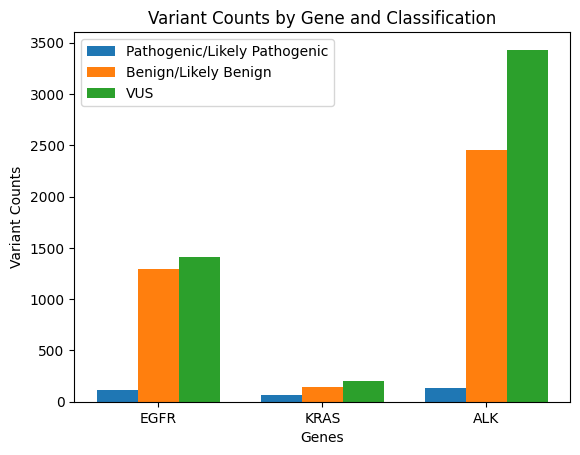

In [10]:
import matplotlib.pyplot as plt

# Data for visualization
genes = ["EGFR", "KRAS", "ALK"]
pathogenic_counts = [119, 62, 131]
benign_counts = [1292, 146, 2458]
vus_counts = [1409, 198, 3432]

# Plotting
bar_width = 0.25
x = range(len(genes))

plt.bar(x, pathogenic_counts, width=bar_width, label="Pathogenic/Likely Pathogenic")
plt.bar([p + bar_width for p in x], benign_counts, width=bar_width, label="Benign/Likely Benign")
plt.bar([p + 2 * bar_width for p in x], vus_counts, width=bar_width, label="VUS")

plt.xticks([p + bar_width for p in x], genes)
plt.xlabel("Genes")
plt.ylabel("Variant Counts")
plt.title("Variant Counts by Gene and Classification")
plt.legend()
plt.show()

Inspecting DataFrames:

In [11]:
for df_name, df in filtered_dfs.items():
    print(f"{df_name}: {len(df)} rows")


EGFR_Pathogenic/Likely_Pathogenic: 119 rows
EGFR_Benign/Likely_Benign: 1292 rows
EGFR_VUS: 1407 rows
KRAS_Pathogenic/Likely_Pathogenic: 62 rows
KRAS_Benign/Likely_Benign: 146 rows
KRAS_VUS: 198 rows
ALK_Pathogenic/Likely_Pathogenic: 131 rows
ALK_Benign/Likely_Benign: 2458 rows
ALK_VUS: 3432 rows


Data summary

In [12]:
# Access and analyze the DataFrames using the dictionary
for df_name, df in filtered_dfs.items():
    # Check if DataFrame is empty
    if df.empty:
        print(f"-------------- {df_name} is Empty ------------------\n")
        continue

    print(f"============== {df_name} Summary ==============\n")

    # General Information
    print(f"Total rows: {len(df)}")
    print(f"Total columns: {len(df.columns)}\n")

    # Summarize nulls and their relative amounts
    print("----- Null Count and Relative Amount per Column -----\n")

    # Calculate null counts and percentages
    null_summary = pd.DataFrame({
    "Null Count": df.isnull().sum(),
    "Percentage (%)": (df.isnull().sum() / len(df)) * 100
    })

    # Display the results
    print(null_summary)


    # A small preview of the data
    print("----- Data Preview -----\n")
    print(df.head().to_string())  # Show first 5 rows in a clean table-like format
    print("\n")

    print("="*50)  # Separator for clarity


============== EGFR_Pathogenic/Likely_Pathogenic Summary ==============

Total rows: 119
Total columns: 39

----- Null Count and Relative Amount per Column -----

              Null Count  Percentage (%)
CHROM                  0        0.000000
POS                    0        0.000000
ID                     0        0.000000
REF                    0        0.000000
ALT                    0        0.000000
QUAL                   0        0.000000
FILTER                 0        0.000000
ALLELEID               0        0.000000
CLNDISDB               0        0.000000
CLNDN                  0        0.000000
CLNHGVS                0        0.000000
CLNREVSTAT             0        0.000000
CLNSIG                 0        0.000000
CLNVC                  0        0.000000
CLNVCSO                0        0.000000
GENEINFO               0        0.000000
MC                     0        0.000000
ORIGIN                 0        0.000000
RS                    44       36.974790
AF_EXAC          

identifying null columns, analyzing their significance and dropping the non relevant columns found

In [ ]:
for df_name, df in filtered_dfs.items():
    print(f"Columns with 0 non-nulls in {df_name}:")
    print(df.columns[df.isna().all()])
    print(len(df.columns))


Columns with 0 non-nulls in EGFR_Pathogenic/Likely_Pathogenic:
Index(['AF_TGP', 'AF_ESP', 'CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL',
       'CLNSIGINCL', 'SCI', 'SCIREVSTAT', 'DBVARID', 'SCIDISDB', 'SCIDN'],
      dtype='object')
39
Columns with 0 non-nulls in EGFR_Benign/Likely_Benign:
Index(['CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'ONC',
       'ONCDISDB', 'ONCDN', 'ONCREVSTAT', 'SCI', 'SCIREVSTAT', 'DBVARID',
       'SCIDISDB', 'SCIDN', 'ONCDISDBINCL', 'ONCDNINCL', 'ONCINCL'],
      dtype='object')
39
Columns with 0 non-nulls in EGFR_VUS:
Index(['CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SCI',
       'SCIREVSTAT', 'DBVARID', 'SCIDISDB', 'SCIDN', 'ONCDISDBINCL',
       'ONCDNINCL', 'ONCINCL'],
      dtype='object')
39
Columns with 0 non-nulls in KRAS_Pathogenic/Likely_Pathogenic:
Index(['AF_TGP', 'AF_ESP', 'CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL',
       'CLNSIGINCL', 'SCI', 'SCIREVSTAT', 'DBVARID', 'SCIDISDB', 'SCIDN',
       'ONCDISDBINCL', 'ONCDNIN

In [13]:
# Identify dropped columns for each DataFrame
for df_name, df in filtered_dfs.items():
    original_columns = set(df.columns)
    non_null_columns = set(df.dropna(axis=1, how='all').columns)
    dropped_columns = original_columns - non_null_columns
    print(f"{df_name} - Dropped Columns:")
    print(dropped_columns)
    print("=" * 50)


EGFR_Pathogenic/Likely_Pathogenic - Dropped Columns:
{'SCIDN', 'SCIDISDB', 'CLNDISDBINCL', 'CLNSIGCONF', 'AF_TGP', 'DBVARID', 'AF_ESP', 'SCI', 'CLNDNINCL', 'SCIREVSTAT', 'CLNSIGINCL'}
EGFR_Benign/Likely_Benign - Dropped Columns:
{'ONCDISDB', 'SCIREVSTAT', 'SCIDN', 'ONC', 'ONCDNINCL', 'SCIDISDB', 'ONCDISDBINCL', 'CLNDISDBINCL', 'CLNSIGCONF', 'DBVARID', 'ONCINCL', 'SCI', 'ONCDN', 'CLNDNINCL', 'ONCREVSTAT', 'CLNSIGINCL'}
EGFR_VUS - Dropped Columns:
{'SCIDN', 'ONCDNINCL', 'SCIDISDB', 'ONCDISDBINCL', 'CLNDISDBINCL', 'CLNSIGCONF', 'DBVARID', 'ONCINCL', 'SCI', 'CLNDNINCL', 'SCIREVSTAT', 'CLNSIGINCL'}
KRAS_Pathogenic/Likely_Pathogenic - Dropped Columns:
{'SCIDN', 'ONCDNINCL', 'SCIDISDB', 'ONCDISDBINCL', 'CLNDISDBINCL', 'CLNSIGCONF', 'AF_TGP', 'DBVARID', 'AF_ESP', 'ONCINCL', 'SCI', 'CLNDNINCL', 'SCIREVSTAT', 'CLNSIGINCL'}
KRAS_Benign/Likely_Benign - Dropped Columns:
{'ONCDISDB', 'SCIREVSTAT', 'SCIDN', 'ONC', 'ONCDNINCL', 'SCIDISDB', 'ONCDISDBINCL', 'CLNDISDBINCL', 'CLNSIGCONF', 'DBVARID', 'ONCI

In [14]:
# Iterate through the dictionary and drop columns with 0 non-null values
for df_name, df in filtered_dfs.items():
    # Drop columns with all NaN values
    filtered_dfs[df_name] = df.dropna(axis=1, how='all')

# Verify the changes
for df_name, df in filtered_dfs.items():
    print(f"After dropping empty columns, {df_name} has {len(df.columns)} columns.")


After dropping empty columns, EGFR_Pathogenic/Likely_Pathogenic has 28 columns.
After dropping empty columns, EGFR_Benign/Likely_Benign has 23 columns.
After dropping empty columns, EGFR_VUS has 27 columns.
After dropping empty columns, KRAS_Pathogenic/Likely_Pathogenic has 25 columns.
After dropping empty columns, KRAS_Benign/Likely_Benign has 23 columns.
After dropping empty columns, KRAS_VUS has 23 columns.
After dropping empty columns, ALK_Pathogenic/Likely_Pathogenic has 22 columns.
After dropping empty columns, ALK_Benign/Likely_Benign has 23 columns.
After dropping empty columns, ALK_VUS has 27 columns.


Re-align columns across all DataFrames

In [15]:
# Get a list of all unique columns across DataFrames
all_columns = set()
for df in filtered_dfs.values():
    all_columns.update(df.columns)
all_columns = sorted(all_columns)

# Re-align all DataFrames to have the same column structure
for df_name, df in filtered_dfs.items():
    filtered_dfs[df_name] = df.reindex(columns=all_columns)
    print(f"{df_name} re-aligned to {len(filtered_dfs[df_name].columns)} columns.")


EGFR_Pathogenic/Likely_Pathogenic re-aligned to 30 columns.
EGFR_Benign/Likely_Benign re-aligned to 30 columns.
EGFR_VUS re-aligned to 30 columns.
KRAS_Pathogenic/Likely_Pathogenic re-aligned to 30 columns.
KRAS_Benign/Likely_Benign re-aligned to 30 columns.
KRAS_VUS re-aligned to 30 columns.
ALK_Pathogenic/Likely_Pathogenic re-aligned to 30 columns.
ALK_Benign/Likely_Benign re-aligned to 30 columns.
ALK_VUS re-aligned to 30 columns.


Data Integrity Validation

In [16]:
print("\n----- Data Integrity Check -----\n")

# Check for duplicates and null counts
for df_name, df in filtered_dfs.items():
    duplicate_count = df.duplicated().sum()
    null_count = df.isnull().sum().sum()
    print(f"{df_name}: {duplicate_count} duplicates, {null_count} total null values.")

# Verify column consistency
columns_list = [df.columns for df in filtered_dfs.values()]
if all(columns.equals(columns_list[0]) for columns in columns_list):
    print("\nAll DataFrames have consistent column structures.")
else:
    print("\nWarning: Inconsistent column structures detected.")



----- Data Integrity Check -----

EGFR_Pathogenic/Likely_Pathogenic: 0 duplicates, 1288 total null values.
EGFR_Benign/Likely_Benign: 0 duplicates, 14131 total null values.
EGFR_VUS: 0 duplicates, 15609 total null values.
KRAS_Pathogenic/Likely_Pathogenic: 0 duplicates, 649 total null values.
KRAS_Benign/Likely_Benign: 0 duplicates, 1527 total null values.
KRAS_VUS: 0 duplicates, 2212 total null values.
ALK_Pathogenic/Likely_Pathogenic: 0 duplicates, 1492 total null values.
ALK_Benign/Likely_Benign: 0 duplicates, 27246 total null values.
ALK_VUS: 0 duplicates, 38550 total null values.

All DataFrames have consistent column structures.


Identify columns that are inconsistent across DataFrames.
Retain only columns that are present in all DataFrames.

In [28]:
# Step 1: Identify all columns across DataFrames
all_columns = set().union(*[df.columns for df in filtered_dfs.values()])

# Step 2: Determine columns to keep (present in all DataFrames)
columns_to_keep = [col for col in all_columns if all(col in df.columns for df in filtered_dfs.values())]

print(f"Columns to keep (consistent across all DataFrames): {columns_to_keep}")
print("\n")

# Step 3: Filter each DataFrame to retain only these columns
for df_name, df in filtered_dfs.items():
    filtered_dfs[df_name] = df[columns_to_keep]
    print(f"Retained columns: {filtered_dfs[df_name].columns.tolist()}\n")
    break


Columns to keep (consistent across all DataFrames): ['POS', 'QUAL', 'ONCDISDB', 'CLNSIG', 'ALT', 'CLNDN', 'CLNDISDB', 'ONCDN', 'CLNHGVS', 'AF_EXAC', 'ORIGIN', 'CLNVCSO', 'MC', 'CLNVI', 'ONC', 'AF_TGP', 'ALLELEID', 'ONCREVSTAT', 'RS', 'REF', 'ONCDNINCL', 'GENEINFO', 'AF_ESP', 'CLNVC', 'CLNREVSTAT', 'ONCINCL', 'ID', 'CHROM', 'FILTER', 'ONCDISDBINCL']


Retained columns: ['POS', 'QUAL', 'ONCDISDB', 'CLNSIG', 'ALT', 'CLNDN', 'CLNDISDB', 'ONCDN', 'CLNHGVS', 'AF_EXAC', 'ORIGIN', 'CLNVCSO', 'MC', 'CLNVI', 'ONC', 'AF_TGP', 'ALLELEID', 'ONCREVSTAT', 'RS', 'REF', 'ONCDNINCL', 'GENEINFO', 'AF_ESP', 'CLNVC', 'CLNREVSTAT', 'ONCINCL', 'ID', 'CHROM', 'FILTER', 'ONCDISDBINCL']



After filtering, confirm that all DataFrames have consistent column structures:

In [29]:
columns_list = [df.columns for df in filtered_dfs.values()]
if all(columns.equals(columns_list[0]) for columns in columns_list):
    print("\nAll DataFrames now have consistent column structures.")
else:
    print("\nWarning: Column inconsistency persists. Investigate further.")



All DataFrames now have consistent column structures.


verify null values:

In [30]:
print(df.isnull().sum())

POS               0
QUAL              0
ONCDISDB        115
CLNSIG            0
ALT               0
CLNDN             0
CLNDISDB          0
ONCDN           115
CLNHGVS           0
AF_EXAC         116
ORIGIN            0
CLNVCSO           0
MC                0
CLNVI            76
ONC             115
AF_TGP          119
ALLELEID          0
ONCREVSTAT      115
RS               44
REF               0
ONCDNINCL       118
GENEINFO          0
AF_ESP          119
CLNVC             0
CLNREVSTAT        0
ONCINCL         118
ID                0
CHROM             0
FILTER            0
ONCDISDBINCL    118
dtype: int64


Detect and Handle Anomalies

Identify Negative Values (Anomalies):

In [31]:
for df_name, df in filtered_dfs.items():
    print(f"\n---- Anomaly Check for {df_name} ----")
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        invalid_values = (df[col] < 0).sum()
        if invalid_values > 0:
            print(f"Column '{col}' has {invalid_values} negative values. Replacing them.")
            median_value = df[col][df[col] >= 0].median()
            df[col] = df[col].apply(lambda x: median_value if x < 0 else x)


---- Anomaly Check for EGFR_Pathogenic/Likely_Pathogenic ----

---- Anomaly Check for EGFR_Benign/Likely_Benign ----

---- Anomaly Check for EGFR_VUS ----

---- Anomaly Check for KRAS_Pathogenic/Likely_Pathogenic ----

---- Anomaly Check for KRAS_Benign/Likely_Benign ----

---- Anomaly Check for KRAS_VUS ----

---- Anomaly Check for ALK_Pathogenic/Likely_Pathogenic ----

---- Anomaly Check for ALK_Benign/Likely_Benign ----

---- Anomaly Check for ALK_VUS ----


Detect and Handle Outliers (IQR Method)

In [32]:
for df_name, df in filtered_dfs.items():
    print(f"\n---- Outlier Detection for {df_name} ----")
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if not outliers.empty:
            print(f"Column '{col}' has {len(outliers)} outliers. Handling them.")
            df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))



---- Outlier Detection for EGFR_Pathogenic/Likely_Pathogenic ----
Column 'POS' has 1 outliers. Handling them.

---- Outlier Detection for EGFR_Benign/Likely_Benign ----
Column 'POS' has 47 outliers. Handling them.

---- Outlier Detection for EGFR_VUS ----
Column 'POS' has 49 outliers. Handling them.

---- Outlier Detection for KRAS_Pathogenic/Likely_Pathogenic ----

---- Outlier Detection for KRAS_Benign/Likely_Benign ----

---- Outlier Detection for KRAS_VUS ----

---- Outlier Detection for ALK_Pathogenic/Likely_Pathogenic ----
Column 'POS' has 21 outliers. Handling them.

---- Outlier Detection for ALK_Benign/Likely_Benign ----
Column 'POS' has 595 outliers. Handling them.

---- Outlier Detection for ALK_VUS ----
Column 'POS' has 458 outliers. Handling them.


 Replace Null Values with Relevant Imputations:

In [36]:
for df_name, df in filtered_dfs.items():
    print(f"\n---- Null Value Replacement for {df_name} ----")
    for col in df.columns:
        if df[col].isnull().sum() > 0:  # Check for nulls
            if df[col].dtype in ['float64', 'int64']:  # Numerical columns
                # Check if column is completely null
                if df[col].dropna().empty:
                    imputation_value = 0  # Default for completely null numerical columns
                else:
                    imputation_value = df[col].dropna().median()  # Median of non-null values
                df[col].fillna(imputation_value, inplace=True)
                print(f"Replaced nulls in numerical column '{col}' with: {imputation_value}")
            else:  # Categorical columns
                if df[col].dropna().empty:
                    imputation_value = "Unknown"  # Default for completely null categorical columns
                else:
                    imputation_value = df[col].dropna().mode()[0]  # Mode of non-null values
                df[col].fillna(imputation_value, inplace=True)
                print(f"Replaced nulls in categorical column '{col}' with: {imputation_value}")




---- Null Value Replacement for EGFR_Pathogenic/Likely_Pathogenic ----
Replaced nulls in numerical column 'AF_TGP' with: 0
Replaced nulls in numerical column 'AF_ESP' with: 0

---- Null Value Replacement for EGFR_Benign/Likely_Benign ----
Replaced nulls in numerical column 'ONCDISDB' with: 0
Replaced nulls in numerical column 'ONCDN' with: 0
Replaced nulls in numerical column 'ONC' with: 0
Replaced nulls in numerical column 'ONCREVSTAT' with: 0
Replaced nulls in numerical column 'ONCDNINCL' with: 0
Replaced nulls in numerical column 'ONCINCL' with: 0
Replaced nulls in numerical column 'ONCDISDBINCL' with: 0

---- Null Value Replacement for EGFR_VUS ----
Replaced nulls in numerical column 'ONCDNINCL' with: 0
Replaced nulls in numerical column 'ONCINCL' with: 0
Replaced nulls in numerical column 'ONCDISDBINCL' with: 0

---- Null Value Replacement for KRAS_Pathogenic/Likely_Pathogenic ----
Replaced nulls in numerical column 'AF_TGP' with: 0
Replaced nulls in numerical column 'ONCDNINCL' 

<ipython-input-36-31b93f252f61>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(imputation_value, inplace=True)
